In [1]:
import xarray as xr
import numpy as np
import os
import glob
import pandas as pd
import tensorflow as tf

class GreenEarthNetGenerator:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob.glob(os.path.join(data_dir, "**/*.nc"), recursive=True))
        self.input_days = 50
        self.target_days = 100
        self.s2_bands = ['s2_B02', 's2_B03', 's2_B04', 's2_B8A']
        self.eobs_vars = ['eobs_tg', 'eobs_fg', 'eobs_hu', 'eobs_pp', 'eobs_qq', 'eobs_rr', 'eobs_tn', 'eobs_tx']

        # Normalization stats from en21x_data.py
        self.eobs_stats = {
            'eobs_tg': {'mean': 8.9066, 'std': 9.7562},
            'eobs_fg': {'mean': 2.7329, 'std': 1.4870},
            'eobs_hu': {'mean': 77.5444, 'std': 13.5114},
            'eobs_pp': {'mean': 1014.3310, 'std': 10.2626},
            'eobs_qq': {'mean': 126.4792, 'std': 97.0552},
            'eobs_rr': {'mean': 1.7713, 'std': 4.1480},
            'eobs_tn': {'mean': 4.7707, 'std': 9.0450},
            'eobs_tx': {'mean': 13.5680, 'std': 11.0820}
        }

        self.dem_vars = ['alos_dem', 'cop_dem', 'nasa_dem']

    def compute_ndvi(self, red, nir):
        # NDVI = (NIR - Red) / (NIR + Red)
        denominator = nir + red
        ndvi = np.divide(nir - red, denominator, out=np.zeros_like(denominator), where=denominator!=0)
        # Normalize to [0, 1] as per methodology: [-1, 1] -> [0, 1]
        ndvi_norm = (ndvi + 1) / 2
        return np.clip(ndvi_norm, 0, 1)

    def normalize_band(self, band_data):
        # Simple min-max normalization or percentile based?
        # The previous code used percentile. Let's stick to a robust normalization or just raw for now if not specified.
        # User request didn't specify normalization, but usually it's good practice.
        # However, for a generator "to be used later", raw values might be preferred unless specified.
        # But previous dataset.py had normalization.
        # Let's keep it simple: Raw values for now, or maybe 0-1 if we know the range.
        # Sentinel-2 is usually 0-10000.
        return np.clip(band_data / 10000.0, 0, 1)

    def __call__(self):
        for file_path in self.files:
            try:
                with xr.open_dataset(file_path) as ds:
                    # Check if we have enough time steps
                    if len(ds.time) < self.input_days + self.target_days:
                        continue

                    # --- Inputs (First 50 days) ---
                    input_slice = slice(0, self.input_days)

                    # 1. Sentinel-2 Bands
                    s2_data = []
                    for band in self.s2_bands:
                        b_data = ds[band].isel(time=input_slice).values
                        # Normalize? Let's do simple division by 10000 for S2
                        s2_data.append(np.clip(b_data / 10000.0, 0, 1))

                    # (50, 128, 128, 4)
                    sentinel2 = np.stack(s2_data, axis=-1)

                    # Check for NaNs in Sentinel-2
                    # If any band is NaN, the pixel is missing/invalid
                    s2_nans = np.isnan(sentinel2).any(axis=-1, keepdims=True) # (50, 128, 128, 1)

                    # Replace NaNs with 0.0
                    sentinel2 = np.nan_to_num(sentinel2, nan=0.0)

                    # 2. Cloud Mask
                    # mask > 0 means cloud/shadow etc.
                    mask = ds['s2_mask'].isel(time=input_slice).values
                    s2_mask = (mask > 0).astype(np.float32)
                    s2_mask = np.expand_dims(s2_mask, axis=-1) # (50, 128, 128, 1)

                    # Update mask to include NaNs (missing data)
                    # If s2_nans is True, s2_mask should be 1 (masked)
                    s2_mask = np.maximum(s2_mask, s2_nans.astype(np.float32))

                    # 3. Weather (E-OBS)
                    weather_data = []
                    for var in self.eobs_vars:
                        w_data = ds[var].isel(time=input_slice).values
                        # Normalize
                        stats = self.eobs_stats[var]
                        w_data = (w_data - stats['mean']) / stats['std']
                        weather_data.append(w_data)

                    # (50, 8)
                    weather = np.stack(weather_data, axis=-1)
                    # Handle NaNs in weather if any (though usually E-OBS is complete or interpolated)
                    weather = np.nan_to_num(weather, nan=0.0)

                    # 4. DEM
                    dem_data = []
                    for var in self.dem_vars:
                        d_data = ds[var].values # (lat, lon)
                        # Normalize by dividing by 500
                        d_data = d_data / 500.0
                        dem_data.append(d_data)

                    # (128, 128, 3)
                    dem = np.stack(dem_data, axis=-1)
                    # Handle NaNs in DEM
                    dem = np.nan_to_num(dem, nan=0.0)

                    # 5. Geomorphology
                    geom = ds['geom_cls'].values # (lat, lon)
                    geomorphology = np.expand_dims(geom, axis=-1) # (128, 128, 1)
                    geomorphology = np.nan_to_num(geomorphology, nan=0.0)

                    # 6. Landcover (ESA WorldCover)
                    lc = ds['esawc_lc'].values # (128, 128)

                    # 7. Time
                    times = ds.time.isel(time=input_slice).values
                    ts = pd.to_datetime(times)

                    # Cyclical features for Day of Year
                    doy = ts.dayofyear
                    doy_sin = np.sin(2 * np.pi * doy / 366.0)
                    doy_cos = np.cos(2 * np.pi * doy / 366.0)

                    # Normalize Year (approximate, assuming data is recent)
                    # Let's map 2017-2021 to roughly [-1, 1] or [0, 1]
                    # 2017 is start, 2021 is end.
                    year_norm = (ts.year - 2019) / 2.0

                    time_feats = np.stack([year_norm, doy_sin, doy_cos], axis=-1).astype(np.float32) # (50, 3)

                    x = {
                        'sentinel2': sentinel2.astype(np.float32),
                        's2_mask': s2_mask.astype(np.float32),
                        'weather': weather.astype(np.float32),
                        'dem': dem.astype(np.float32),
                        'geomorphology': geomorphology.astype(np.float32),
                        'time': time_feats
                    }

                    # --- Targets (Next 100 days) ---
                    target_slice = slice(self.input_days+4, self.input_days + self.target_days, 5)

                    red_t = ds['s2_B04'].isel(time=target_slice).values
                    nir_t = ds['s2_B8A'].isel(time=target_slice).values

                    ndvi_t = self.compute_ndvi(red_t, nir_t)

                    # Apply cloud mask
                    mask_t = ds['s2_mask'].isel(time=target_slice).values

                    # Use np.where for safe broadcasting/masking
                    ndvi_t = np.where(mask_t > 0, np.nan, ndvi_t)

                    avail_t = ds['s2_avail'].isel(time=target_slice).values
                    # avail_t is (time,)
                    # Broadcast to (time, 128, 128)
                    avail_t = avail_t[:, None, None]
                    ndvi_t = np.where(avail_t == 0, np.nan, ndvi_t)

                    # Prepare y with shape (20, 128, 128, 2)
                    # Channel 0: NDVI
                    # Channel 1: Landcover (repeated)

                    # Expand NDVI to (20, 128, 128, 1)
                    ndvi_t = np.expand_dims(ndvi_t, axis=-1)

                    # Prepare Landcover (1, 128, 128, 1) -> (20, 128, 128, 1)
                    lc_expanded = np.expand_dims(np.expand_dims(lc, axis=0), axis=-1)
                    lc_t = np.tile(lc_expanded, (ndvi_t.shape[0], 1, 1, 1))

                    y = np.concatenate([ndvi_t, lc_t], axis=-1).astype(np.float32)

                    yield x, y

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    def get_dataset(self) -> tf.data.Dataset:
        # Define output signature
        output_signature = (
            {
                'sentinel2': tf.TensorSpec(shape=(50, 128, 128, 4), dtype=tf.float32),
                's2_mask': tf.TensorSpec(shape=(50, 128, 128, 1), dtype=tf.float32),
                'weather': tf.TensorSpec(shape=(50, 8), dtype=tf.float32),
                'dem': tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
                'geomorphology': tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
                'time': tf.TensorSpec(shape=(50, 3), dtype=tf.float32)
            },
            tf.TensorSpec(shape=(20, 128, 128, 2), dtype=tf.float32)
        )

        return tf.data.Dataset.from_generator(
            self.__call__,
            output_signature=output_signature
        )


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles, name='quantile_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.quantiles = quantiles

    def call(self, y_true, y_pred):
        # y_true: (B, 20, 128, 128, 2) - Channel 0 is NDVI
        # y_pred: (B, NumQuantiles, 20, 128, 128, 1)

        y_true_ndvi = y_true[..., 0:1] # (B, 20, 128, 128, 1)

        # Expand y_true to match y_pred quantiles
        # (B, 1, 20, 128, 128, 1)
        y_true_exp = tf.expand_dims(y_true_ndvi, axis=1)

        # Mask NaNs
        mask = tf.logical_not(tf.math.is_nan(y_true_exp))
        y_true_safe = tf.where(mask, y_true_exp, 0.0)

        loss = 0.0
        for i, q in enumerate(self.quantiles):
            q_pred = y_pred[:, i:i+1, ...] # (B, 1, 20, 128, 128, 1)
            error = y_true_safe - q_pred
            q_loss = tf.maximum(q * error, (q - 1) * error)
            loss += q_loss

        # Apply mask
        loss = tf.where(mask, loss, 0.0)

        # Average over valid pixels
        num_valid = tf.maximum(tf.reduce_sum(tf.cast(mask, tf.float32)), 1.0)
        return tf.reduce_sum(loss) / num_valid

    def get_config(self):
        config = super().get_config()
        config.update({'quantiles': self.quantiles})
        return config

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class VegetationScoreLoss(tf.keras.losses.Loss):
    """
    Vegetation Score Loss.

    Maximizes the Vegetation Score:
    VegScore = 2 - 1/mean(NNSE_veg)
    where NNSE = 1 / (2 - NSE)
    and NSE is Nash-Sutcliffe Efficiency on cloud-free vegetation pixels.

    Loss = 1 - VegScore (to minimize)
         = 1 - (2 - 1/mean(NNSE))
         = 1/mean(NNSE) - 1

    Vegetation classes (ESA WorldCover):
    10: Tree cover
    20: Shrubland
    30: Grassland
    """
    def __init__(self, name='vegetation_score_loss', **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # y_true: (batch, 20, 128, 128, 2) [NDVI, Landcover]
        # y_pred: (batch, 20, 128, 128, 1)

        y_true_ndvi = y_true[..., 0:1]
        landcover = y_true[..., 1:2]

        # Mask for valid pixels (not NaN)
        valid_mask = tf.logical_not(tf.math.is_nan(y_true_ndvi))

        # Mask for vegetation pixels (10, 20, 30)
        # ESA WorldCover: 10=Trees, 20=Shrubland, 30=Grassland
        veg_mask = (landcover == 10) | (landcover == 20) | (landcover == 30)

        # Combined mask: Valid AND Vegetation
        mask = valid_mask & veg_mask

        # Replace NaNs with zeros for calculation
        y_true_safe = tf.where(valid_mask, y_true_ndvi, 0.0)

        # Count valid observations per pixel
        valid_count_per_pixel = tf.reduce_sum(tf.cast(valid_mask, tf.float32), axis=1, keepdims=True) # (B, 1, 128, 128, 1)

        # Sum of true values
        sum_true = tf.reduce_sum(y_true_safe, axis=1, keepdims=True)
        mean_true = tf.math.divide_no_nan(sum_true, valid_count_per_pixel)

        # Numerator: Sum of squared errors
        sse = tf.reduce_sum(tf.square(y_true_safe - y_pred) * tf.cast(valid_mask, tf.float32), axis=1, keepdims=True)

        # Denominator: Sum of squared deviations from mean
        sst = tf.reduce_sum(tf.square(y_true_safe - mean_true) * tf.cast(valid_mask, tf.float32), axis=1, keepdims=True)

        # NSE = 1 - SSE/SST
        epsilon = 1e-6
        nse = 1.0 - (sse / (sst + epsilon))

        # NNSE = 1 / (2 - NSE)
        nnse = 1.0 / (2.0 - nse)

        # Now average NNSE over vegetation pixels
        # veg_mask is (B, 20, 128, 128, 1). We need a spatial mask (B, 1, 128, 128, 1)
        # A pixel is vegetation if it is vegetation at any time step (it's static)
        spatial_veg_mask = veg_mask[:, 0:1, :, :, :] # (B, 1, 128, 128, 1)

        masked_nnse = nnse * tf.cast(spatial_veg_mask, tf.float32)

        sum_nnse = tf.reduce_sum(masked_nnse)
        count_veg = tf.reduce_sum(tf.cast(spatial_veg_mask, tf.float32))

        mean_nnse = tf.math.divide_no_nan(sum_nnse, count_veg)

        # Loss = 1/mean_nnse - 1
        loss = tf.where(
            count_veg > 0,
            (1.0 / (mean_nnse + epsilon)) - 1.0,
            0.0
        )

        return loss

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles, veg_weight=0.1, name='combined_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.quantiles = quantiles
        self.veg_weight = veg_weight
        self.quantile_loss = QuantileLoss(quantiles)
        self.veg_loss = VegetationScoreLoss()

    def call(self, y_true, y_pred):
        # y_true: (B, 20, 128, 128, 2)
        # y_pred: (B, NumQuantiles, 20, 128, 128, 1)

        # 1. Quantile Loss
        q_loss = self.quantile_loss(y_true, y_pred)

        # 2. Vegetation Score Loss
        # Use the median prediction (usually the middle quantile) for the vegetation score
        # Assuming quantiles are sorted, median is at index len(quantiles)//2
        median_idx = len(self.quantiles) // 2

        # Extract median prediction: (B, NumQuantiles, 20, 128, 128, 1) -> (B, 20, 128, 128, 1)
        # Slicing with integer index removes the dimension
        y_pred_median = y_pred[:, median_idx, ...]

        v_loss = self.veg_loss(y_true, y_pred_median)

        return q_loss + self.veg_weight * v_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            'quantiles': self.quantiles,
            'veg_weight': self.veg_weight
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class QuantileRegressionHead(layers.Layer):
    def __init__(self, forecast_horizon, quantiles, **kwargs):
        super().__init__(**kwargs)
        self.forecast_horizon = forecast_horizon
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)

        self.quantile_heads = [
            tf.keras.Sequential([
                layers.Conv2D(256, 3, padding='same', activation='relu'),
                layers.Conv2D(128, 3, padding='same', activation='relu'),
                layers.Conv2D(forecast_horizon, 1)
            ], name=f'q_head_{i}')
            for i in range(self.num_quantiles)
        ]

    def call(self, inputs):
        outputs = []
        for head in self.quantile_heads:
            pred = head(inputs)
            pred = tf.transpose(pred, perm=[0, 3, 1, 2]) # (B, 20, 128, 128)
            pred = tf.expand_dims(pred, axis=-1) # (B, 20, 128, 128, 1)
            outputs.append(pred)

        return tf.stack(outputs, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "forecast_horizon": self.forecast_horizon,
            "quantiles": self.quantiles,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class ConvFormer(tf.keras.Model):
    def __init__(self, forecast_horizon=20, quantiles=[0.1, 0.5, 0.9], **kwargs):
        super().__init__(**kwargs)
        self.forecast_horizon = forecast_horizon
        self.quantiles = quantiles

        # --- Encoder ---
        self.spatial_encoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, padding='same', activation='relu')
        ], name='spatial_encoder')

        self.td_spatial = layers.TimeDistributed(self.spatial_encoder)

        self.conv_lstm = layers.ConvLSTM2D(
            filters=128, kernel_size=3, padding='same', return_sequences=False
        )

        # --- Fusion ---
        self.weather_mlp = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu')
        ], name='weather_mlp')

        self.dem_encoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, padding='same', activation='relu')
        ], name='dem_encoder')

        self.fusion_conv = layers.Conv2D(256, 3, padding='same', activation='relu')

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D(2),
            layers.Conv2D(128, 3, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(64, 3, padding='same', activation='relu')
        ], name='decoder')

        # --- Head ---
        self.head = QuantileRegressionHead(forecast_horizon, quantiles)

    def call(self, inputs):
        if isinstance(inputs, dict):
            sentinel2 = inputs['sentinel2']
            weather = inputs['weather']
            dem = inputs['dem']
        else:
            sentinel2, weather, dem = inputs

        x_spatial = self.td_spatial(sentinel2)
        x_temporal = self.conv_lstm(x_spatial)

        w_feat = tf.reduce_mean(weather, axis=1)
        w_emb = self.weather_mlp(w_feat)
        w_emb = tf.reshape(w_emb, (-1, 1, 1, 128))
        w_emb = tf.tile(w_emb, [1, 32, 32, 1])

        d_emb = self.dem_encoder(dem)

        fused = layers.concatenate([x_temporal, w_emb, d_emb], axis=-1)
        fused = self.fusion_conv(fused)

        decoded = self.decoder(fused)

        outputs = self.head(decoded)

        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "forecast_horizon": self.forecast_horizon,
            "quantiles": self.quantiles,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [3]:
import os
import sys
import argparse
import tensorflow as tf

def train_convformer(
    train_dir,
    val_dir=None,
    batch_size=4,
    epochs=200,
    learning_rate=1e-4,
    checkpoint_dir='checkpoints',
    log_dir='logs/convformer',
    quantiles=[0.1, 0.5, 0.9]
):
    # Create directories
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    print(f"Loading data from {train_dir}...")

    # 1. Dataset
    generator = GreenEarthNetGenerator(train_dir)
    train_dataset = generator.get_dataset()

    # Shuffle and Batch
    train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_dataset = None
    if val_dir and os.path.exists(val_dir):
        print(f"Loading validation data from {val_dir}...")
        val_generator = GreenEarthNetGenerator(val_dir)
        val_dataset = val_generator.get_dataset()
        val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # 2. Model
    print("Creating ConvFormer model...")
    model = ConvFormer(forecast_horizon=20, quantiles=quantiles)

    # Build model to print summary
    # Create dummy input to build the model
    dummy_input = {
        'sentinel2': tf.zeros((1, 50, 128, 128, 4)),
        's2_mask': tf.zeros((1, 50, 128, 128, 1)),
        'weather': tf.zeros((1, 50, 8)),
        'dem': tf.zeros((1, 128, 128, 3)),
        'geomorphology': tf.zeros((1, 128, 128, 1)),
        'time': tf.zeros((1, 50, 3))
    }
    model(dummy_input)
    model.summary()

    # 3. Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = CombinedLoss(quantiles=quantiles, veg_weight=0.1)

    model.compile(optimizer=optimizer, loss=loss)

    # 4. Callbacks
    checkpoint_path = os.path.join(checkpoint_dir, 'convformer_best.weights.h5')

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=25,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    ]

    # 5. Train
    print("Starting training...")
    try:
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks
        )
    except KeyboardInterrupt:
        print("Training interrupted.")
        return model

    # Save final weights
    final_weights_path = os.path.join(checkpoint_dir, 'convformer_final.weights.h5')
    print(f"Saving final weights to {final_weights_path}...")

    model.save_weights(final_weights_path)
    del model
    K.clear_session()

    print("Training complete.")
    return model

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Train ConvFormer model')
    parser.add_argument(
        '--train-dir',
        type=str,
        default='/home/me/workspace/probformer/data/greenearthnet/traint_test',
        help='Directory containing training .nc files'
    )
    parser.add_argument(
        '--val-dir',
        type=str,
        default=None,
        help='Directory containing validation .nc files'
    )
    parser.add_argument(
        '--batch-size',
        type=int,
        default=4,
        help='Batch size for training'
    )
    parser.add_argument(
        '--epochs',
        type=int,
        default=1000,
        help='Maximum number of epochs'
    )
    parser.add_argument(
        '--learning-rate',
        type=float,
        default=1e-3,
        help='Initial learning rate'
    )
    parser.add_argument(
        '--checkpoint-dir',
        type=str,
        default='checkpoints',
        help='Directory to save model checkpoints'
    )
    parser.add_argument(
        '--log-dir',
        type=str,
        default='logs/convformer',
        help='Directory for TensorBoard logs'
    )

    args = parser.parse_args()

    # Use env var if argument is default and env var is set?
    # Or just rely on args. The user specified the path in the prompt.

    train_convformer(
        train_dir=args.train_dir,
        val_dir=args.val_dir,
        batch_size=args.batch_size,
        epochs=args.epochs,
        learning_rate=args.learning_rate,
        checkpoint_dir=args.checkpoint_dir,
        log_dir=args.log_dir
    )


In [5]:
train_convformer(
    train_dir="/content/greenearthnet",
    val_dir=None,
    batch_size=8,
    epochs=200,
    learning_rate=1e-3,
    checkpoint_dir="/content/checkpoints",
    log_dir="/content/logs"
)

Loading data from /content/greenearthnet...
Creating ConvFormer model...


Model: "conv_former"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_encoder (Sequential)    │ (1, 32, 32, 128)       │        93,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (1, 50, 32, 32, 128)   │        93,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (1, 32, 32, 128)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ weather_mlp (Sequential)        │ (1, 128)               │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dem_encoder (Sequential)        │ (1, 32, 32, 128)       │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (1, 32, 32, 256)       │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (1, 128, 128, 64)      │       368,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantile_regression_head        │ ?                      │     1,335,996 │
│ (QuantileRegressionHead)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,965,660 (15.13 MB)

 Trainable params: 3,965,660 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/200
      1/Unknown 48s 48s/step - loss: 77.4387
Epoch 1: loss improved from inf to 77.43867, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step - loss: 77.4387 - learning_rate: 0.0010
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 18.8366
Epoch 2: loss improved from 77.43867 to 18.83665, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 18.8366 - learning_rate: 0.0010
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 168.3135
Epoch 3: loss did not improve from 18.83665


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 168.3135 - learning_rate: 0.0010
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7.6138
Epoch 4: loss improved from 18.83665 to 7.61385, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 7.6138 - learning_rate: 0.0010
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 35.4806
Epoch 5: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 35.4806 - learning_rate: 0.0010
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 35.0659
Epoch 6: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 35.0659 - learning_rate: 0.0010
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 29.9829
Epoch 7: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 29.9829 - learning_rate: 0.0010
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 18.6863
Epoch 8: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 18.6863 - learning_rate: 0.0010
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 20.0382
Epoch 9: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 20.0382 - learning_rate: 0.0010
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 17.3236
Epoch 10: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 17.3236 - learning_rate: 0.0010
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8.4143
Epoch 11: loss did not improve from 7.61385


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 8.4143 - learning_rate: 0.0010
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4.5002
Epoch 12: loss improved from 7.61385 to 4.50023, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 4.5002 - learning_rate: 0.0010
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.4571
Epoch 13: loss improved from 4.50023 to 3.45714, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.4571 - learning_rate: 0.0010
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.2757
Epoch 14: loss improved from 3.45714 to 3.27570, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.2757 - learning_rate: 0.0010
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.2996
Epoch 15: loss did not improve from 3.27570


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.2996 - learning_rate: 0.0010
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.5807
Epoch 16: loss did not improve from 3.27570


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.5807 - learning_rate: 0.0010
Epoch 17/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.7275
Epoch 17: loss did not improve from 3.27570


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.7275 - learning_rate: 0.0010
Epoch 18/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.0193
Epoch 18: loss improved from 3.27570 to 3.01930, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 3.0193 - learning_rate: 0.0010
Epoch 19/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2.1697
Epoch 19: loss improved from 3.01930 to 2.16968, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.1697 - learning_rate: 0.0010
Epoch 20/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.6464
Epoch 20: loss improved from 2.16968 to 1.64643, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.6464 - learning_rate: 0.0010
Epoch 21/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.3729
Epoch 21: loss improved from 1.64643 to 1.37290, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3729 - learning_rate: 0.0010
Epoch 22/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.3301
Epoch 22: loss improved from 1.37290 to 1.33013, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3301 - learning_rate: 0.0010
Epoch 23/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.4506
Epoch 23: loss did not improve from 1.33013


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.4506 - learning_rate: 0.0010
Epoch 24/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.6183
Epoch 24: loss did not improve from 1.33013


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.6183 - learning_rate: 0.0010
Epoch 25/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.5366
Epoch 25: loss did not improve from 1.33013


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.5366 - learning_rate: 0.0010
Epoch 26/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.3801
Epoch 26: loss did not improve from 1.33013


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3801 - learning_rate: 0.0010
Epoch 27/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.2310
Epoch 27: loss improved from 1.33013 to 1.23102, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.2310 - learning_rate: 0.0010
Epoch 28/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.0569
Epoch 28: loss improved from 1.23102 to 1.05691, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.0569 - learning_rate: 0.0010
Epoch 29/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.9141
Epoch 29: loss improved from 1.05691 to 0.91413, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.9141 - learning_rate: 0.0010
Epoch 30/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.8630
Epoch 30: loss improved from 0.91413 to 0.86299, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.8630 - learning_rate: 0.0010
Epoch 31/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.8312
Epoch 31: loss improved from 0.86299 to 0.83118, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.8312 - learning_rate: 0.0010
Epoch 32/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.8191
Epoch 32: loss improved from 0.83118 to 0.81905, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.8191 - learning_rate: 0.0010
Epoch 33/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.8176
Epoch 33: loss improved from 0.81905 to 0.81757, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.8176 - learning_rate: 0.0010
Epoch 34/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.7959
Epoch 34: loss improved from 0.81757 to 0.79594, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.7959 - learning_rate: 0.0010
Epoch 35/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7554
Epoch 35: loss improved from 0.79594 to 0.75545, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7554 - learning_rate: 0.0010
Epoch 36/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.7233
Epoch 36: loss improved from 0.75545 to 0.72331, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.7233 - learning_rate: 0.0010
Epoch 37/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7161
Epoch 37: loss improved from 0.72331 to 0.71609, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.7161 - learning_rate: 0.0010
Epoch 38/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7017
Epoch 38: loss improved from 0.71609 to 0.70167, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7017 - learning_rate: 0.0010
Epoch 39/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6823
Epoch 39: loss improved from 0.70167 to 0.68232, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6823 - learning_rate: 0.0010
Epoch 40/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6526
Epoch 40: loss improved from 0.68232 to 0.65259, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6526 - learning_rate: 0.0010
Epoch 41/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.6271
Epoch 41: loss improved from 0.65259 to 0.62715, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6271 - learning_rate: 0.0010
Epoch 42/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6114
Epoch 42: loss improved from 0.62715 to 0.61135, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6114 - learning_rate: 0.0010
Epoch 43/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6148
Epoch 43: loss did not improve from 0.61135


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6148 - learning_rate: 0.0010
Epoch 44/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.6162
Epoch 44: loss did not improve from 0.61135


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.6162 - learning_rate: 0.0010
Epoch 45/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.6095
Epoch 45: loss improved from 0.61135 to 0.60954, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6095 - learning_rate: 0.0010
Epoch 46/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6013
Epoch 46: loss improved from 0.60954 to 0.60128, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6013 - learning_rate: 0.0010
Epoch 47/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5945
Epoch 47: loss improved from 0.60128 to 0.59452, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5945 - learning_rate: 0.0010
Epoch 48/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5858
Epoch 48: loss improved from 0.59452 to 0.58579, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5858 - learning_rate: 0.0010
Epoch 49/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5772
Epoch 49: loss improved from 0.58579 to 0.57716, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5772 - learning_rate: 0.0010
Epoch 50/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5725
Epoch 50: loss improved from 0.57716 to 0.57254, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5725 - learning_rate: 0.0010
Epoch 51/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5694
Epoch 51: loss improved from 0.57254 to 0.56941, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5694 - learning_rate: 0.0010
Epoch 52/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5642
Epoch 52: loss improved from 0.56941 to 0.56422, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5642 - learning_rate: 0.0010
Epoch 53/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5558
Epoch 53: loss improved from 0.56422 to 0.55580, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5558 - learning_rate: 0.0010
Epoch 54/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5440
Epoch 54: loss improved from 0.55580 to 0.54404, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5440 - learning_rate: 0.0010
Epoch 55/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5391
Epoch 55: loss improved from 0.54404 to 0.53906, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5391 - learning_rate: 0.0010
Epoch 56/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5387
Epoch 56: loss improved from 0.53906 to 0.53874, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5387 - learning_rate: 0.0010
Epoch 57/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.5346
Epoch 57: loss improved from 0.53874 to 0.53458, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5346 - learning_rate: 0.0010
Epoch 58/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5436
Epoch 58: loss did not improve from 0.53458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5436 - learning_rate: 0.0010
Epoch 59/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5599
Epoch 59: loss did not improve from 0.53458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5599 - learning_rate: 0.0010
Epoch 60/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.5536
Epoch 60: loss did not improve from 0.53458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.5536 - learning_rate: 0.0010
Epoch 61/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5433
Epoch 61: loss did not improve from 0.53458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5433 - learning_rate: 0.0010
Epoch 62/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5540
Epoch 62: loss did not improve from 0.53458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5540 - learning_rate: 0.0010
Epoch 63/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5418
Epoch 63: loss did not improve from 0.53458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5418 - learning_rate: 0.0010
Epoch 64/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5294
Epoch 64: loss improved from 0.53458 to 0.52941, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5294 - learning_rate: 0.0010
Epoch 65/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5346
Epoch 65: loss did not improve from 0.52941


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5346 - learning_rate: 0.0010
Epoch 66/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5274
Epoch 66: loss improved from 0.52941 to 0.52741, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5274 - learning_rate: 0.0010
Epoch 67/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5228
Epoch 67: loss improved from 0.52741 to 0.52283, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5228 - learning_rate: 0.0010
Epoch 68/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5259
Epoch 68: loss did not improve from 0.52283


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5259 - learning_rate: 0.0010
Epoch 69/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5153
Epoch 69: loss improved from 0.52283 to 0.51533, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5153 - learning_rate: 0.0010
Epoch 70/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5189
Epoch 70: loss did not improve from 0.51533


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5189 - learning_rate: 0.0010
Epoch 71/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5080
Epoch 71: loss improved from 0.51533 to 0.50799, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5080 - learning_rate: 0.0010
Epoch 72/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5075
Epoch 72: loss improved from 0.50799 to 0.50748, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5075 - learning_rate: 0.0010
Epoch 73/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5000
Epoch 73: loss improved from 0.50748 to 0.49998, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5000 - learning_rate: 0.0010
Epoch 74/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5007
Epoch 74: loss did not improve from 0.49998


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.5007 - learning_rate: 0.0010
Epoch 75/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4968
Epoch 75: loss improved from 0.49998 to 0.49677, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4968 - learning_rate: 0.0010
Epoch 76/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4930
Epoch 76: loss improved from 0.49677 to 0.49296, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4930 - learning_rate: 0.0010
Epoch 77/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4878
Epoch 77: loss improved from 0.49296 to 0.48777, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4878 - learning_rate: 0.0010
Epoch 78/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4847
Epoch 78: loss improved from 0.48777 to 0.48466, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4847 - learning_rate: 0.0010
Epoch 79/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4790
Epoch 79: loss improved from 0.48466 to 0.47903, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4790 - learning_rate: 0.0010
Epoch 80/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4805
Epoch 80: loss did not improve from 0.47903


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4805 - learning_rate: 0.0010
Epoch 81/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4782
Epoch 81: loss improved from 0.47903 to 0.47823, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4782 - learning_rate: 0.0010
Epoch 82/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4664
Epoch 82: loss improved from 0.47823 to 0.46635, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4664 - learning_rate: 0.0010
Epoch 83/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4834
Epoch 83: loss did not improve from 0.46635


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4834 - learning_rate: 0.0010
Epoch 84/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5006
Epoch 84: loss did not improve from 0.46635


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5006 - learning_rate: 0.0010
Epoch 85/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4904
Epoch 85: loss did not improve from 0.46635


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4904 - learning_rate: 0.0010
Epoch 86/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4659
Epoch 86: loss improved from 0.46635 to 0.46589, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4659 - learning_rate: 0.0010
Epoch 87/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4898
Epoch 87: loss did not improve from 0.46589


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4898 - learning_rate: 0.0010
Epoch 88/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4578
Epoch 88: loss improved from 0.46589 to 0.45782, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4578 - learning_rate: 0.0010
Epoch 89/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4426
Epoch 89: loss improved from 0.45782 to 0.44263, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4426 - learning_rate: 0.0010
Epoch 90/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.4599
Epoch 90: loss did not improve from 0.44263


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4599 - learning_rate: 0.0010
Epoch 91/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.4281
Epoch 91: loss improved from 0.44263 to 0.42805, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4281 - learning_rate: 0.0010
Epoch 92/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.4216
Epoch 92: loss improved from 0.42805 to 0.42160, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4216 - learning_rate: 0.0010
Epoch 93/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4184
Epoch 93: loss improved from 0.42160 to 0.41840, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4184 - learning_rate: 0.0010
Epoch 94/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3924
Epoch 94: loss improved from 0.41840 to 0.39237, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3924 - learning_rate: 0.0010
Epoch 95/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4111
Epoch 95: loss did not improve from 0.39237


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4111 - learning_rate: 0.0010
Epoch 96/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4121
Epoch 96: loss did not improve from 0.39237


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4121 - learning_rate: 0.0010
Epoch 97/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3816
Epoch 97: loss improved from 0.39237 to 0.38157, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3816 - learning_rate: 0.0010
Epoch 98/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4007
Epoch 98: loss did not improve from 0.38157


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4007 - learning_rate: 0.0010
Epoch 99/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3557
Epoch 99: loss improved from 0.38157 to 0.35571, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3557 - learning_rate: 0.0010
Epoch 100/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3840
Epoch 100: loss did not improve from 0.35571


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3840 - learning_rate: 0.0010
Epoch 101/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4003
Epoch 101: loss did not improve from 0.35571


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4003 - learning_rate: 0.0010
Epoch 102/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4007
Epoch 102: loss did not improve from 0.35571


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4007 - learning_rate: 0.0010
Epoch 103/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.3524
Epoch 103: loss improved from 0.35571 to 0.35238, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.3524 - learning_rate: 0.0010
Epoch 104/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.3591
Epoch 104: loss did not improve from 0.35238


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3591 - learning_rate: 0.0010
Epoch 105/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3727
Epoch 105: loss did not improve from 0.35238


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3727 - learning_rate: 0.0010
Epoch 106/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3443
Epoch 106: loss improved from 0.35238 to 0.34429, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3443 - learning_rate: 0.0010
Epoch 107/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3652
Epoch 107: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3652 - learning_rate: 0.0010
Epoch 108/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4270
Epoch 108: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4270 - learning_rate: 0.0010
Epoch 109/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4247
Epoch 109: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.4247 - learning_rate: 0.0010
Epoch 110/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3602
Epoch 110: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3602 - learning_rate: 0.0010
Epoch 111/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3759
Epoch 111: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3759 - learning_rate: 0.0010
Epoch 112/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3610
Epoch 112: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3610 - learning_rate: 0.0010
Epoch 113/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3669
Epoch 113: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3669 - learning_rate: 0.0010
Epoch 114/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3687
Epoch 114: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3687 - learning_rate: 0.0010
Epoch 115/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3472
Epoch 115: loss did not improve from 0.34429


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3472 - learning_rate: 0.0010
Epoch 116/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.3854
Epoch 116: loss did not improve from 0.34429

Epoch 116: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3854 - learning_rate: 0.0010
Epoch 117/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3433
Epoch 117: loss improved from 0.34429 to 0.34333, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3433 - learning_rate: 5.0000e-04
Epoch 118/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3456
Epoch 118: loss did not improve from 0.34333


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3456 - learning_rate: 5.0000e-04
Epoch 119/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3305
Epoch 119: loss improved from 0.34333 to 0.33045, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3305 - learning_rate: 5.0000e-04
Epoch 120/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3442
Epoch 120: loss did not improve from 0.33045


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3442 - learning_rate: 5.0000e-04
Epoch 121/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3323
Epoch 121: loss did not improve from 0.33045


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3323 - learning_rate: 5.0000e-04
Epoch 122/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3323
Epoch 122: loss did not improve from 0.33045


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3323 - learning_rate: 5.0000e-04
Epoch 123/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3371
Epoch 123: loss did not improve from 0.33045


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3371 - learning_rate: 5.0000e-04
Epoch 124/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3260
Epoch 124: loss improved from 0.33045 to 0.32596, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3260 - learning_rate: 5.0000e-04
Epoch 125/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3355
Epoch 125: loss did not improve from 0.32596


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3355 - learning_rate: 5.0000e-04
Epoch 126/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3264
Epoch 126: loss did not improve from 0.32596


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3264 - learning_rate: 5.0000e-04
Epoch 127/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3300
Epoch 127: loss did not improve from 0.32596


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3300 - learning_rate: 5.0000e-04
Epoch 128/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3287
Epoch 128: loss did not improve from 0.32596


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3287 - learning_rate: 5.0000e-04
Epoch 129/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3250
Epoch 129: loss improved from 0.32596 to 0.32499, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3250 - learning_rate: 5.0000e-04
Epoch 130/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3292
Epoch 130: loss did not improve from 0.32499


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3292 - learning_rate: 5.0000e-04
Epoch 131/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3228
Epoch 131: loss improved from 0.32499 to 0.32279, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3228 - learning_rate: 5.0000e-04
Epoch 132/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3270
Epoch 132: loss did not improve from 0.32279


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3270 - learning_rate: 5.0000e-04
Epoch 133/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3227
Epoch 133: loss improved from 0.32279 to 0.32273, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3227 - learning_rate: 5.0000e-04
Epoch 134/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3238
Epoch 134: loss did not improve from 0.32273


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3238 - learning_rate: 5.0000e-04
Epoch 135/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3228
Epoch 135: loss did not improve from 0.32273


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3228 - learning_rate: 5.0000e-04
Epoch 136/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3212
Epoch 136: loss improved from 0.32273 to 0.32118, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3212 - learning_rate: 5.0000e-04
Epoch 137/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3225
Epoch 137: loss did not improve from 0.32118


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3225 - learning_rate: 5.0000e-04
Epoch 138/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3195
Epoch 138: loss improved from 0.32118 to 0.31952, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3195 - learning_rate: 5.0000e-04
Epoch 139/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3216
Epoch 139: loss did not improve from 0.31952


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3216 - learning_rate: 5.0000e-04
Epoch 140/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3186
Epoch 140: loss improved from 0.31952 to 0.31855, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3186 - learning_rate: 5.0000e-04
Epoch 141/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3201
Epoch 141: loss did not improve from 0.31855


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3201 - learning_rate: 5.0000e-04
Epoch 142/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3180
Epoch 142: loss improved from 0.31855 to 0.31802, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3180 - learning_rate: 5.0000e-04
Epoch 143/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3186
Epoch 143: loss did not improve from 0.31802


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3186 - learning_rate: 5.0000e-04
Epoch 144/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3175
Epoch 144: loss improved from 0.31802 to 0.31750, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3175 - learning_rate: 5.0000e-04
Epoch 145/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3172
Epoch 145: loss improved from 0.31750 to 0.31719, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3172 - learning_rate: 5.0000e-04
Epoch 146/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3167
Epoch 146: loss improved from 0.31719 to 0.31673, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3167 - learning_rate: 5.0000e-04
Epoch 147/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3159
Epoch 147: loss improved from 0.31673 to 0.31592, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3159 - learning_rate: 5.0000e-04
Epoch 148/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3160
Epoch 148: loss did not improve from 0.31592


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3160 - learning_rate: 5.0000e-04
Epoch 149/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3150
Epoch 149: loss improved from 0.31592 to 0.31498, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3150 - learning_rate: 5.0000e-04
Epoch 150/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3151
Epoch 150: loss did not improve from 0.31498


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3151 - learning_rate: 5.0000e-04
Epoch 151/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3141
Epoch 151: loss improved from 0.31498 to 0.31405, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3141 - learning_rate: 5.0000e-04
Epoch 152/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3142
Epoch 152: loss did not improve from 0.31405


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3142 - learning_rate: 5.0000e-04
Epoch 153/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3132
Epoch 153: loss improved from 0.31405 to 0.31323, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3132 - learning_rate: 5.0000e-04
Epoch 154/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3132
Epoch 154: loss improved from 0.31323 to 0.31322, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3132 - learning_rate: 5.0000e-04
Epoch 155/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3124
Epoch 155: loss improved from 0.31322 to 0.31237, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3124 - learning_rate: 5.0000e-04
Epoch 156/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3123
Epoch 156: loss improved from 0.31237 to 0.31229, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3123 - learning_rate: 5.0000e-04
Epoch 157/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3116
Epoch 157: loss improved from 0.31229 to 0.31161, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3116 - learning_rate: 5.0000e-04
Epoch 158/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3114
Epoch 158: loss improved from 0.31161 to 0.31141, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3114 - learning_rate: 5.0000e-04
Epoch 159/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3109
Epoch 159: loss improved from 0.31141 to 0.31086, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3109 - learning_rate: 5.0000e-04
Epoch 160/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3106
Epoch 160: loss improved from 0.31086 to 0.31060, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3106 - learning_rate: 5.0000e-04
Epoch 161/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3101
Epoch 161: loss improved from 0.31060 to 0.31015, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3101 - learning_rate: 5.0000e-04
Epoch 162/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3098
Epoch 162: loss improved from 0.31015 to 0.30979, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3098 - learning_rate: 5.0000e-04
Epoch 163/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3094
Epoch 163: loss improved from 0.30979 to 0.30945, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3094 - learning_rate: 5.0000e-04
Epoch 164/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3090
Epoch 164: loss improved from 0.30945 to 0.30900, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3090 - learning_rate: 5.0000e-04
Epoch 165/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3088
Epoch 165: loss improved from 0.30900 to 0.30876, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3088 - learning_rate: 5.0000e-04
Epoch 166/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3082
Epoch 166: loss improved from 0.30876 to 0.30824, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3082 - learning_rate: 5.0000e-04
Epoch 167/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3081
Epoch 167: loss improved from 0.30824 to 0.30807, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3081 - learning_rate: 5.0000e-04
Epoch 168/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3075
Epoch 168: loss improved from 0.30807 to 0.30754, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3075 - learning_rate: 5.0000e-04
Epoch 169/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3073
Epoch 169: loss improved from 0.30754 to 0.30733, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3073 - learning_rate: 5.0000e-04
Epoch 170/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3069
Epoch 170: loss improved from 0.30733 to 0.30690, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3069 - learning_rate: 5.0000e-04
Epoch 171/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3066
Epoch 171: loss improved from 0.30690 to 0.30658, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3066 - learning_rate: 5.0000e-04
Epoch 172/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3063
Epoch 172: loss improved from 0.30658 to 0.30626, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3063 - learning_rate: 5.0000e-04
Epoch 173/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3059
Epoch 173: loss improved from 0.30626 to 0.30589, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3059 - learning_rate: 5.0000e-04
Epoch 174/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3056
Epoch 174: loss improved from 0.30589 to 0.30562, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3056 - learning_rate: 5.0000e-04
Epoch 175/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3052
Epoch 175: loss improved from 0.30562 to 0.30521, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3052 - learning_rate: 5.0000e-04
Epoch 176/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3049
Epoch 176: loss improved from 0.30521 to 0.30492, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3049 - learning_rate: 5.0000e-04
Epoch 177/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3046
Epoch 177: loss improved from 0.30492 to 0.30459, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3046 - learning_rate: 5.0000e-04
Epoch 178/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3042
Epoch 178: loss improved from 0.30459 to 0.30422, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3042 - learning_rate: 5.0000e-04
Epoch 179/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3039
Epoch 179: loss improved from 0.30422 to 0.30395, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3039 - learning_rate: 5.0000e-04
Epoch 180/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3036
Epoch 180: loss improved from 0.30395 to 0.30357, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3036 - learning_rate: 5.0000e-04
Epoch 181/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3032
Epoch 181: loss improved from 0.30357 to 0.30324, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3032 - learning_rate: 5.0000e-04
Epoch 182/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3029
Epoch 182: loss improved from 0.30324 to 0.30292, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3029 - learning_rate: 5.0000e-04
Epoch 183/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3025
Epoch 183: loss improved from 0.30292 to 0.30252, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3025 - learning_rate: 5.0000e-04
Epoch 184/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3022
Epoch 184: loss improved from 0.30252 to 0.30219, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3022 - learning_rate: 5.0000e-04
Epoch 185/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3019
Epoch 185: loss improved from 0.30219 to 0.30187, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3019 - learning_rate: 5.0000e-04
Epoch 186/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3015
Epoch 186: loss improved from 0.30187 to 0.30151, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3015 - learning_rate: 5.0000e-04
Epoch 187/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3012
Epoch 187: loss improved from 0.30151 to 0.30122, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3012 - learning_rate: 5.0000e-04
Epoch 188/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3009
Epoch 188: loss improved from 0.30122 to 0.30090, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3009 - learning_rate: 5.0000e-04
Epoch 189/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3005
Epoch 189: loss improved from 0.30090 to 0.30055, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3005 - learning_rate: 5.0000e-04
Epoch 190/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3002
Epoch 190: loss improved from 0.30055 to 0.30023, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3002 - learning_rate: 5.0000e-04
Epoch 191/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2999
Epoch 191: loss improved from 0.30023 to 0.29989, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2999 - learning_rate: 5.0000e-04
Epoch 192/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2995
Epoch 192: loss improved from 0.29989 to 0.29954, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2995 - learning_rate: 5.0000e-04
Epoch 193/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2992
Epoch 193: loss improved from 0.29954 to 0.29920, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2992 - learning_rate: 5.0000e-04
Epoch 194/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2989
Epoch 194: loss improved from 0.29920 to 0.29887, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2989 - learning_rate: 5.0000e-04
Epoch 195/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2985
Epoch 195: loss improved from 0.29887 to 0.29852, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2985 - learning_rate: 5.0000e-04
Epoch 196/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2981
Epoch 196: loss improved from 0.29852 to 0.29815, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2981 - learning_rate: 5.0000e-04
Epoch 197/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2978
Epoch 197: loss improved from 0.29815 to 0.29778, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2978 - learning_rate: 5.0000e-04
Epoch 198/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2974
Epoch 198: loss improved from 0.29778 to 0.29741, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2974 - learning_rate: 5.0000e-04
Epoch 199/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2970
Epoch 199: loss improved from 0.29741 to 0.29703, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2970 - learning_rate: 5.0000e-04
Epoch 200/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2967
Epoch 200: loss improved from 0.29703 to 0.29668, saving model to /content/checkpoints/convformer_best.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2967 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 200.
Saving final weights to /content/checkpoints/convformer_final.weights.h5...
Training complete.


<ConvFormer name=conv_former, built=True>

# Visualization

Loaded 4 samples.
Loading weights from /content/checkpoints/convformer_best.weights.h5...
Weights loaded successfully.


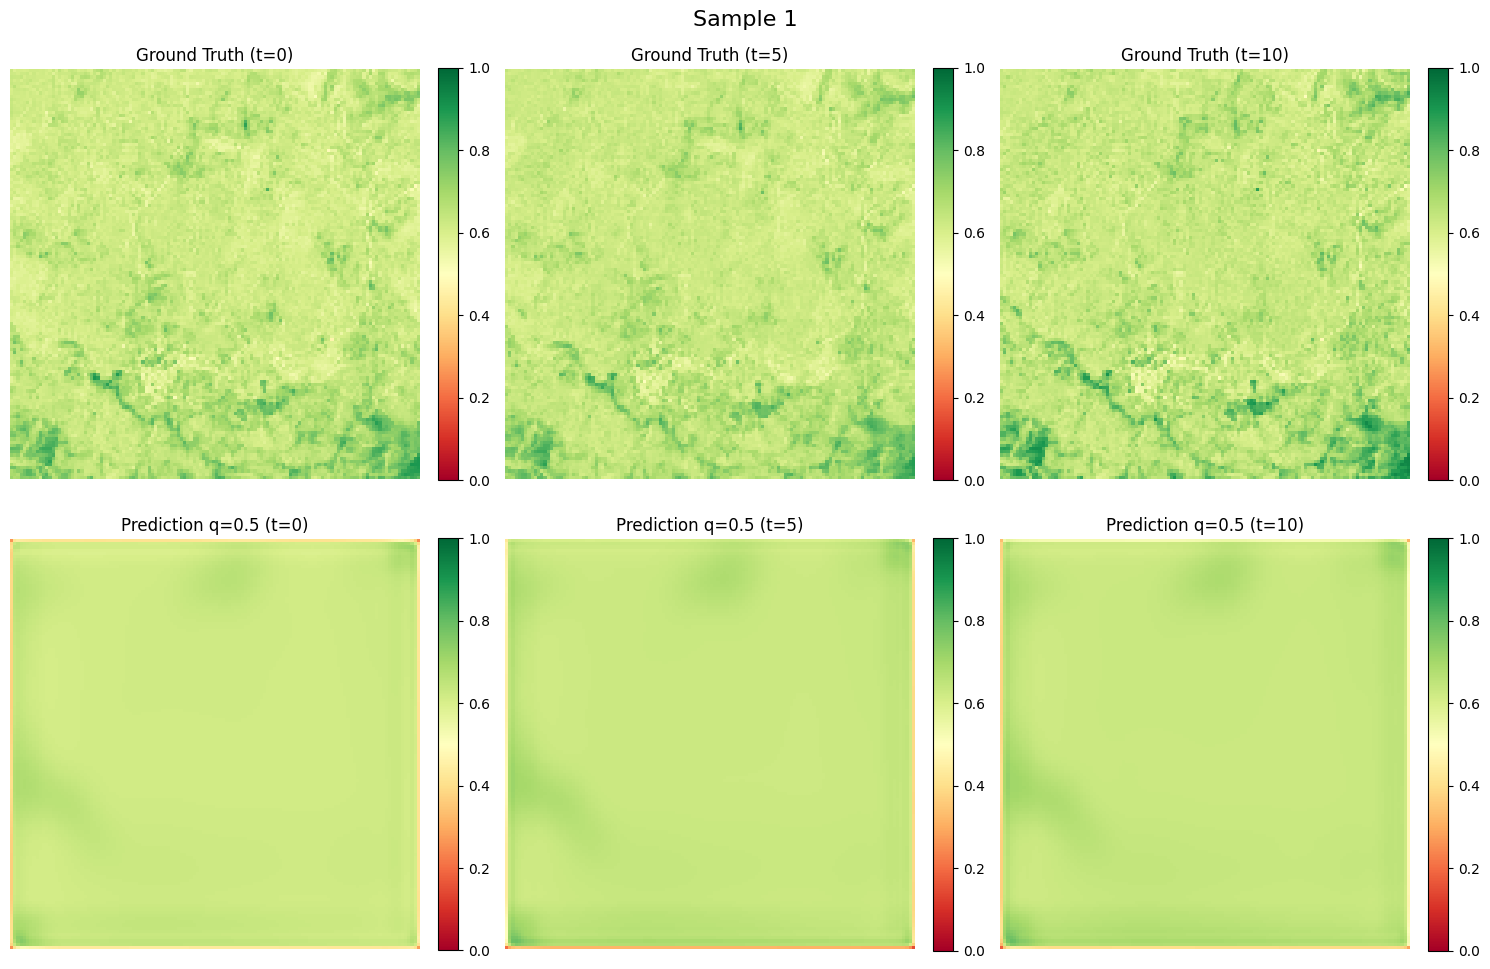

Sample 1 Metrics:
  MSE: 0.0046
  MAE: 0.0411


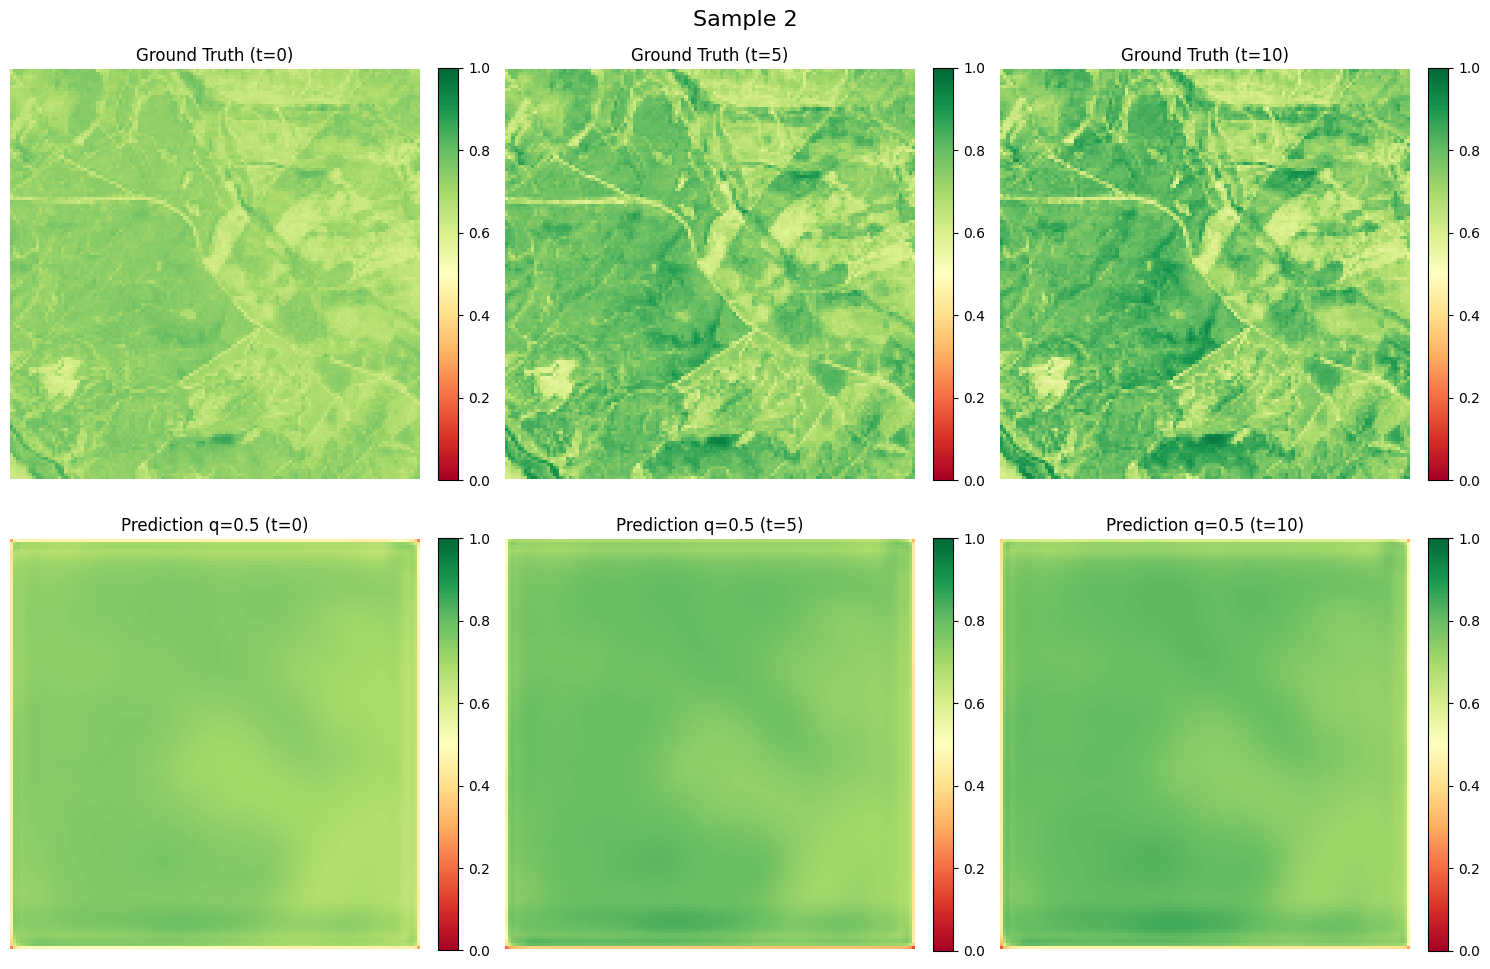

Sample 2 Metrics:
  MSE: 0.0066
  MAE: 0.0557


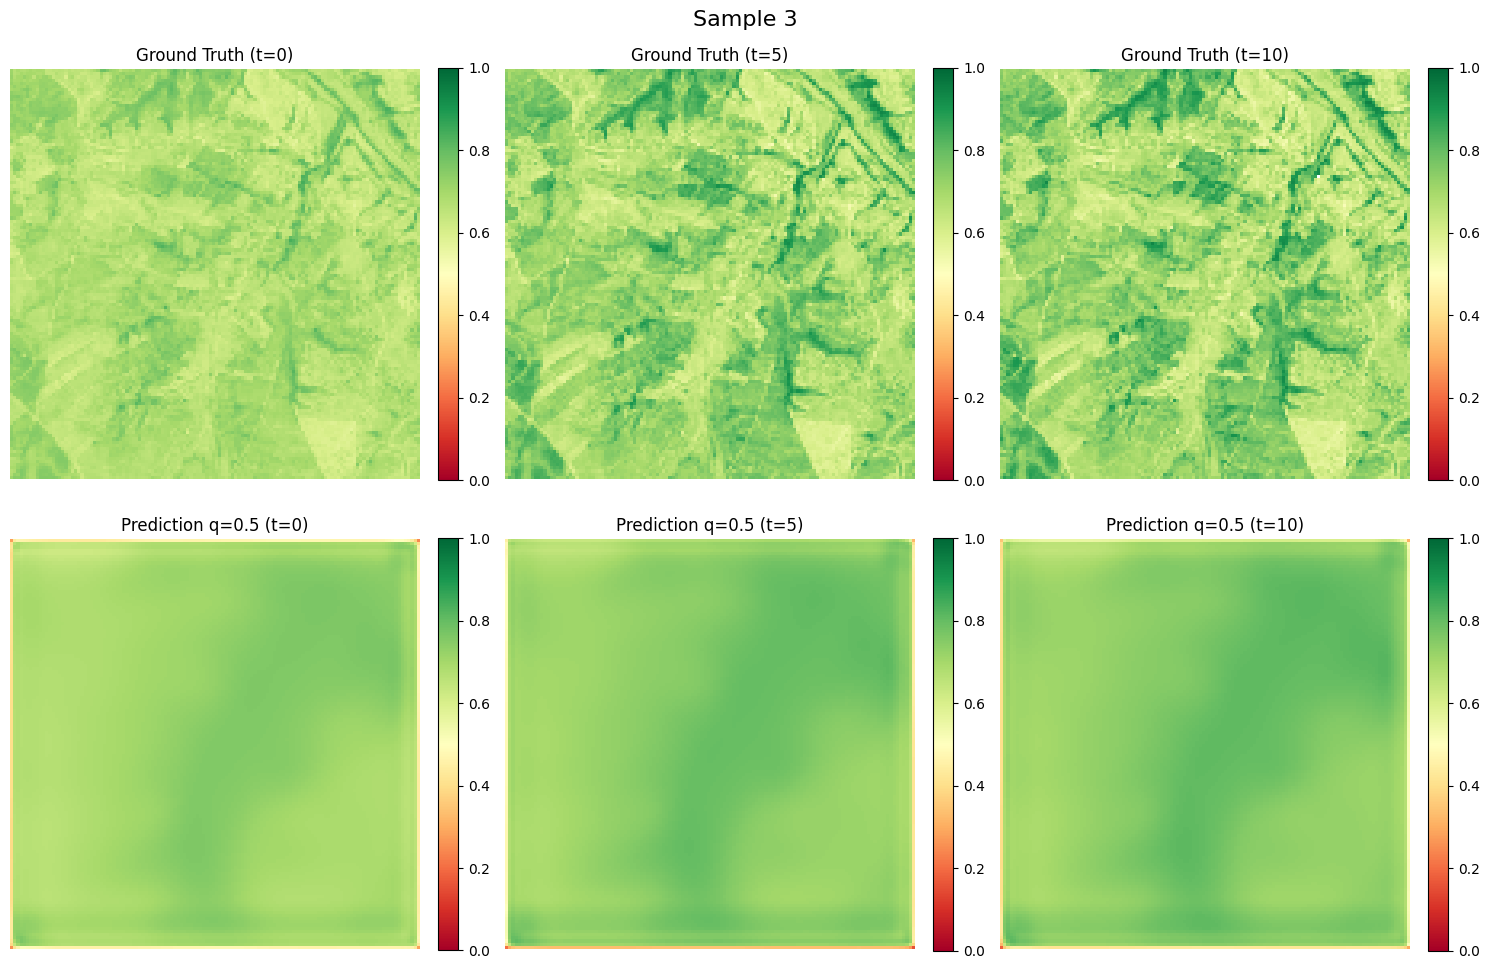

Sample 3 Metrics:
  MSE: 0.0097
  MAE: 0.0754


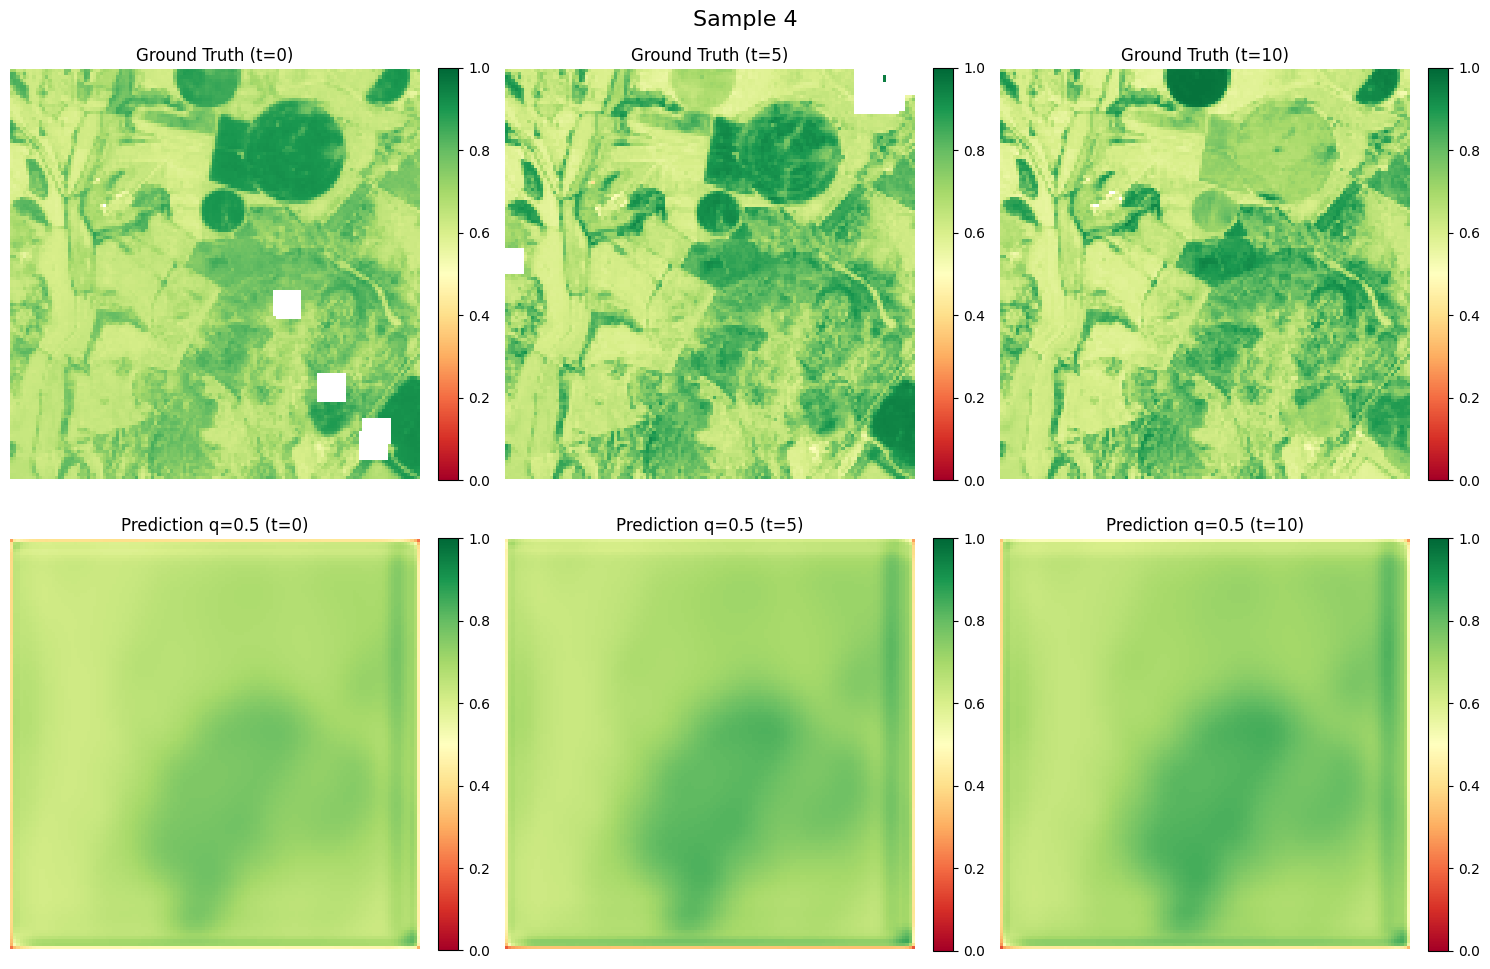

Sample 4 Metrics:
  MSE: 0.0113
  MAE: 0.0808


In [8]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = '/content/greenearthnet'
NUM_SAMPLES = 4

generator = GreenEarthNetGenerator(DATA_DIR)
dataset = generator.get_dataset()

# Take 5 samples
samples = []
for x, y in dataset.take(NUM_SAMPLES):
    samples.append((x, y))

print(f"Loaded {len(samples)} samples.")


CHECKPOINT_PATH = '/content/checkpoints/convformer_best.weights.h5'
QUANTILES = [0.1, 0.5, 0.9]

model = ConvFormer(forecast_horizon=20, quantiles=QUANTILES)

# Build the model by passing a dummy input or calling build
# The model expects a dict of inputs. We can use one sample to build it.
dummy_x = samples[0][0]
# Add batch dimension
dummy_x_batch = {k: tf.expand_dims(v, 0) for k, v in dummy_x.items()}

model(dummy_x_batch)

print(f"Loading weights from {CHECKPOINT_PATH}...")
try:
    model.load_weights(CHECKPOINT_PATH)
    print("Weights loaded successfully.")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Make sure you have trained the model and the checkpoint exists.")



def plot_sample(x, y_true, y_pred, sample_idx):
    # y_true: (20, 128, 128)
    # y_pred: (n_quantile, 20, 128, 128)

    # Extract median prediction (q=0.5, idx=1)
    pred_median = y_pred[1] # (20, 128, 128)

    # Select time steps to visualize (e.g., start, middle, end)
    time_steps = [0, 5, 10]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Sample {sample_idx+1}', fontsize=16)

    for i, t in enumerate(time_steps):
        # Ground Truth
        ax_gt = axes[0, i]
        im_gt = ax_gt.imshow(y_true[t], cmap='RdYlGn', vmin=0, vmax=1)
        ax_gt.set_title(f'Ground Truth (t={t})')
        ax_gt.axis('off')
        plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)

        # Prediction
        ax_pred = axes[1, i]
        im_pred = ax_pred.imshow(pred_median[t], cmap='RdYlGn', vmin=0, vmax=1)
        ax_pred.set_title(f'Prediction q=0.5 (t={t})')
        ax_pred.axis('off')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Calculate Metrics for this sample
    # Mask NaNs in y_true (if any)
    mask = ~np.isnan(y_true)

    mse = np.mean((y_true[mask] - pred_median[mask])**2)
    mae = np.mean(np.abs(y_true[mask] - pred_median[mask]))

    print(f"Sample {sample_idx+1} Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")

# Run prediction and plotting
for i, (x, y) in enumerate(samples):
    # Add batch dimension
    x_batch = {k: tf.expand_dims(v, 0) for k, v in x.items()}

    # Predict
    y_pred = model(x_batch)

    # Convert to numpy
    y_pred_np = y_pred[0, :, :, :, :, 0].numpy()    # Shape: (3, 20, 128, 128)
    y_true_np = y[:, :, :, 0].numpy()             # Shape: (20, 128, 128)

    plot_sample(x, y_true_np, y_pred_np, i)